### Import

In [375]:
import os
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import spectral.io.aviris as aviris
import colour
from PIL import Image
from scipy.stats import multivariate_normal as mnorm
from scipy import ndimage
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits import mplot3d
from skimage import io, color
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from scipy.spatial.distance import squareform
from sklearn import datasets
from colour.plotting import *
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import silhouette_score

### Fonts

In [376]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}

### Parameters

In [377]:
mu1 = np.array([-3,0])
mu2 = np.array([+3,0])
sigma1 = np.array([[1,0],[0,1]])
sigma2 = np.array([[1,0],[0,1]])
no_points1 = 20
no_points2 = 20
np.random.seed(40)

### Distributions

In [378]:
dist1 = mnorm(mu1,sigma1)
dist2 = mnorm(mu2,sigma2)

# Distance Based Clustering
Distance-based algorithm rely on the fact that points we can find centroids of our clusters. A point belongs to a the cluster with the centroid closest to it. For data that doesn't show any clustering from a distance point of view, the points will still be assigned to whatever centroid they are closest to, but there is nothing that sets the points assigned to one cluster apart from those assigned to a different cluster. Clustering happens when the the distances between points belonging to one cluster are collectively smaller than the distances between the same points and points belonging to a different cluster. 

### The ultimate non-clustered dataset
The following dataset is pinacle of non-clustering. We place n number of points on a grid an simple alternate what cluster they belong too, creating a chessboard like pattern of points belonging to one of two clusters. 

In [393]:
resolution = 11
x,y = np.meshgrid(np.linspace(-1,1,resolution),np.linspace(-1,1,resolution))
c = np.zeros((resolution,1))
c[:,0] = np.array(list(range(resolution))) % 2
c[np.where(c == 0)[0],0] = -1
c = np.dot(c,c.T)
x = x.flatten()
y = y.flatten()
c = c.flatten()
c[np.where(c == -1)[0]] = 0
Xcheck = np.vstack((x,y)).T

### Centroids and silhouette score
As we expected, when we compute the centroids of the two 'clusters', the are essentially zero and overlap completely. In addition, the silhouette score, a measure the compares inter and intracluster distances between points is also essentially zero, indicating there is absolutely no clustering.

In [394]:
idx0 = np.where(c == 0)[0]
idx1 = np.where(c == 1)[0]
centroid0 = np.mean(Xcheck[idx0,:],axis=0)
centroid1 = np.mean(Xcheck[idx1,:],axis=0)
score = silhouette_score(Xcheck, c, metric='euclidean')
print(centroid0)
print(centroid1)
print(score)

[  4.44089210e-17  -2.96059473e-17]
[  4.00408304e-17  -1.45603020e-17]
-0.0152504668419


### Plot the non-clustered dataset

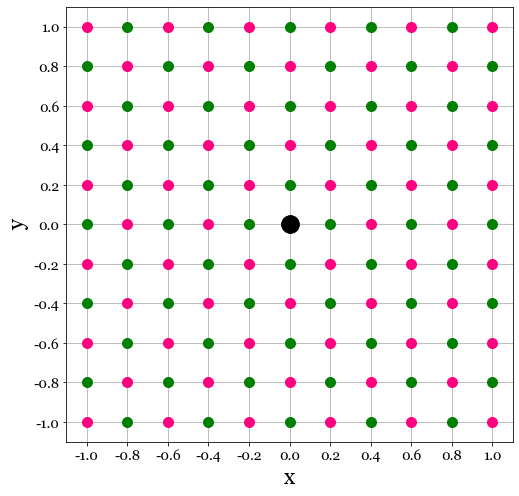

In [396]:
plt.figure(figsize=(8,8))
plt.scatter(Xcheck[idx0,0],Xcheck[idx0,1],color=(0,0.5,0.0),s=100,zorder=100)
plt.scatter(Xcheck[idx1,0],Xcheck[idx1,1],color=(1.0,0.0,0.5),s=100,zorder=100)
plt.scatter(centroid0[0],centroid0[1],c='k',s=300,zorder=100)
plt.scatter(centroid1[0],centroid1[1],c='k',s=300,zorder=100)
plt.xlabel('x',fontsize=22,**csfont);
plt.ylabel('y',fontsize=22,**csfont,rotation=90);
plt.yticks(np.linspace(-1,1,resolution),labels=np.linspace(-1,1,resolution),fontsize=14,**csfont);
plt.xticks(np.linspace(-1,1,resolution),labels=np.linspace(-1,1,resolution),fontsize=14,**csfont);
plt.grid()
plt.savefig('../../assets/figures/017/checkerboard_clustering.png',dpi=300,bbox_inches="tight")

### A more realistic scenario
In a more realistic scenario, let us predefine two cluster centroids at \[-0.5,0\] and \[0.5,0\]. We then generate a large number of uniformly distributed random points. For each point, we compute the distance two both centroids. If one distance is below the threshold for one of the clusters, a point is added to that cluster. Anything in between, we discard the point and try again until we have n points, equally divided over two clusters. This is the ideal scenario for a distance based clustering algorithm like k-means, which should work perfectly on this synthetic data. However, it is so perfect that the two other clustering approaches discussed below will also have little trouble with this particular scenario. It is when we tweak certain parameters on this method of creating and assigning random points, we will start to see when one algorithm breaks down, whereas another starts to flourish. 

In [397]:
centroid0 = np.expand_dims(np.array([-0.5,0]),-1).T
centroid1 = np.expand_dims(np.array([+0.5,0]),-1).T
count_class0 = 0
count_class1 = 0
no_points_0 = 100
no_points_1 = 100
c = []
threshold = 0.4
Xdist = []
while (1==1):
    xy = np.expand_dims(np.random.random(2),1).T
    xy = (xy - 0.5) * 2
    dis0 = cdist(xy,centroid0)
    dis1 = cdist(xy,centroid1)
    if (dis0 < threshold and count_class0 < no_points_0):
        c.append(0)
        Xdist.append(xy)
        count_class0 = count_class0 + 1
    if (dis1 < threshold and count_class1 < no_points_1):
        c.append(1)
        Xdist.append(xy)
        count_class1 = count_class1 + 1
    if (count_class1 == no_points_1 and count_class0 == no_points_0):
        break
Xdist = np.squeeze(np.array(Xdist))
c = np.array(c)
idx0 = np.where(c == 0)[0]
idx1 = np.where(c == 1)[0]

### Run K-means and compute metrics
The centroids are spot on, and the silhoutte measure is reasonably high, meaning k-means has performed well on this data, as expected.

In [398]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(Xdist)
pred_centroids = kmeans.cluster_centers_
pred_labels = kmeans.labels_
score = silhouette_score(Xdist, pred_labels, metric='euclidean')
print(pred_centroids)
print(score)

[[ 0.48644108 -0.00464627]
 [-0.4997161  -0.04039012]]
0.641383717942


### Plot

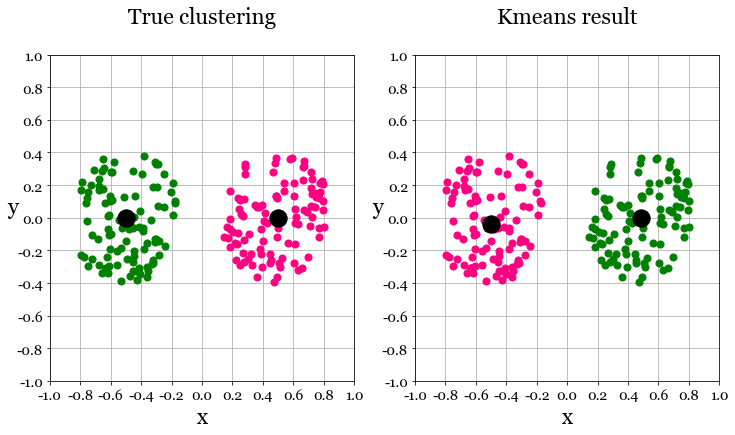

In [399]:
plt.figure(figsize=(12,6))
idx0 = np.where(c == 0)[0]
idx1 = np.where(c == 1)[0]
plt.subplot(1,2,1)
plt.scatter(Xdist[idx0,0],Xdist[idx0,1],color=(0.0,0.5,0),s=50,zorder=100)
plt.scatter(Xdist[idx1,0],Xdist[idx1,1],color=(1.0,0.0,0.5),s=50,zorder=100)
plt.scatter(centroid0[0,0],centroid0[0,1],c='k',s=300,zorder=100)
plt.scatter(centroid1[0,0],centroid1[0,1],c='k',s=300,zorder=100)
plt.xlabel('x',fontsize=22,**csfont);
plt.ylabel('y',fontsize=22,**csfont,rotation=0);
plt.yticks(np.linspace(-1,1,resolution),labels=np.linspace(-1,1,resolution),fontsize=14,**csfont);
plt.xticks(np.linspace(-1,1,resolution),labels=np.linspace(-1,1,resolution),fontsize=14,**csfont);
plt.grid()
plt.title('True clustering\n',fontsize=22,**csfont);


plt.subplot(1,2,2)
idx0 = np.where(pred_labels == 0)[0]
idx1 = np.where(pred_labels == 1)[0]
plt.scatter(Xdist[idx0,0],Xdist[idx0,1],color=(0,0.5,0),s=50,zorder=100)
plt.scatter(Xdist[idx1,0],Xdist[idx1,1],color=(1.0,0.0,0.5),s=50,zorder=100)
plt.scatter(pred_centroids[0,0],pred_centroids[0,1],c='k',s=300,zorder=100)
plt.scatter(pred_centroids[1,0],pred_centroids[1,1],c='k',s=300,zorder=100)
plt.xlabel('x',fontsize=22,**csfont);
plt.ylabel('y',fontsize=22,**csfont,rotation=0);
plt.yticks(np.linspace(-1,1,resolution),labels=np.linspace(-1,1,resolution),fontsize=14,**csfont);
plt.xticks(np.linspace(-1,1,resolution),labels=np.linspace(-1,1,resolution),fontsize=14,**csfont);
plt.grid()
plt.title('Kmeans result\n',fontsize=22,**csfont);
plt.savefig('../../assets/matplotlib/017_distance_clustering.png',dpi=300,bbox_inches="tight")

### Gaussian Data Set
What if we use a Gaussian, rather than uniform process to generate our clusters? Would this present any problem for k-means? The answer is no when then gaussians we use have no covariance, meaning they are aligned with both x and y axes. 

In [401]:
np.random.seed(400)
mu0 = np.array([-0.5,0])
mu1 = np.array([+0.5,0])
sigma0 = np.array([[0.75, 0.75], [0.75, 1]]) * 0.2
sigma1 = np.array([[0.75, 0.75], [0.75, 1]]) * 0.2
distr0 = mnorm(mu0,sigma0)
distr1 = mnorm(mu1,sigma1)
x0 = distr0.rvs(no_points_0)
x1 = distr1.rvs(no_points_1)
Xgauss = np.vstack((x0,x1))
c = np.hstack((np.zeros((no_points_0)),np.ones((no_points_0))))
c = np.expand_dims(c,-1)

### Run K-means and compute metrics
However, non-zero covariance, which rotates the distrubtion and the points we draw from it can cause k-means to fail. Euclidean distance, in this case, is no longer the appropriate metric for deciding wether a point belongs to either of the two clusters, since this does not factor in the covariance or correlational structure of our data.

In [402]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(Xgauss)
pred_centroids = kmeans.cluster_centers_
pred_labels = kmeans.labels_
score = silhouette_score(Xgauss, pred_labels, metric='euclidean')
print(pred_centroids)
print(score)

[[-0.44518464 -0.25784738]
 [ 0.57512177  0.29279404]]
0.413845412499


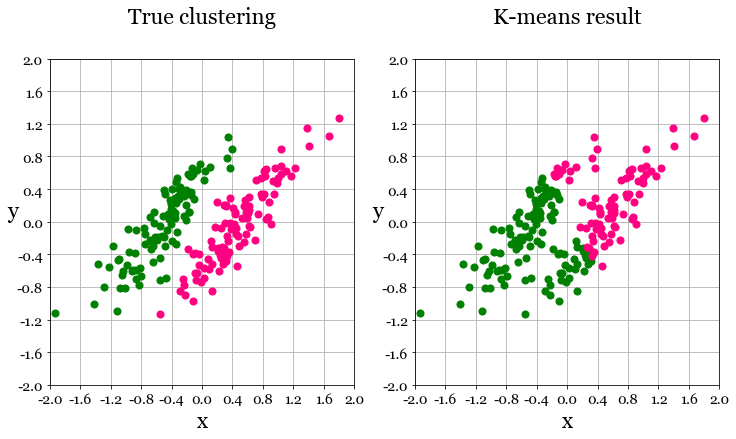

In [403]:
idx0 = np.where(c == 0)[0]
idx1 = np.where(c == 1)[0]
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(Xgauss[idx0,0],Xgauss[idx0,1],color=(0,0.5,0),s=50,zorder=100)
plt.scatter(Xgauss[idx1,0],Xgauss[idx1,1],color=(1.0,0.0,0.5),s=50,zorder=100)
plt.xlabel('x',fontsize=22,**csfont);
plt.ylabel('y',fontsize=22,**csfont,rotation=0);
plt.yticks(np.linspace(-2,2,resolution),labels=np.linspace(-2,2,resolution),fontsize=14,**csfont);
plt.xticks(np.linspace(-2,2,resolution),labels=np.linspace(-2,2,resolution),fontsize=14,**csfont);
plt.grid()
plt.axis((-2,2,-2,2))
plt.title('True clustering\n',fontsize=22,**csfont,pad=10);
plt.savefig('../../assets/matplotlib/017_distance_clustering_fail1.png',dpi=300,bbox_inches="tight")

plt.subplot(1,2,2)
idx0 = np.where(pred_labels == 0)[0]
idx1 = np.where(pred_labels == 1)[0]
plt.scatter(Xgauss[idx0,0],Xgauss[idx0,1],color=(0,0.5,0),s=50,zorder=100)
plt.scatter(Xgauss[idx1,0],Xgauss[idx1,1],color=(1.0,0.0,0.5),s=50,zorder=100)
plt.xlabel('x',fontsize=22,**csfont);
plt.ylabel('y',fontsize=22,**csfont,rotation=0);
plt.yticks(np.linspace(-2,2,resolution),labels=np.linspace(-2,2,resolution),fontsize=14,**csfont);
plt.xticks(np.linspace(-2,2,resolution),labels=np.linspace(-2,2,resolution),fontsize=14,**csfont);
plt.grid()
plt.axis((-2,2,-2,2))
plt.title('K-means result\n',fontsize=22,**csfont,pad=10);
plt.savefig('../../assets/matplotlib/017_distance_clustering_fail2.png',dpi=300,bbox_inches="tight")

# Distribution Based Clustering

### Gaussian Mixture Models
When we have good reason to assume that our points are 1) generated by some gaussian process and 2) our features show a fair bit of covariance, we should use a model that specifically tries to find clusters based on these premises. Gaussian Mixture models do exactly that. This type of distribution based model iterates over the points to find an n number of guassian or normal distributions that maximize the likelihood of observing all points where they are. This process of Maximum likelihood estimation (MLE) provides a powerful of understand the processes underlying your observations, if you have some reasonable idea about what distributions the processes follow. 


### Gaussian Mixture Models Maximum Likelihood Estimation - Basic Example
If we had a long list of people's height in cm, we could in principle create a histogram and fit a normal distribution to it, like in the approach below

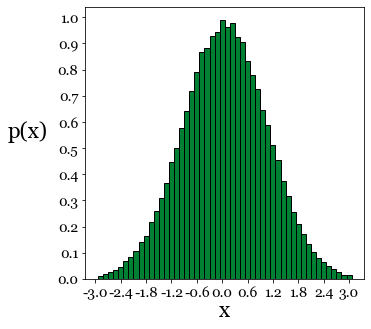

In [408]:
dist = mnorm([0],[1])
x = dist.rvs(100000)
resolution = 51
hx,hy = np.histogram(x,np.linspace(-3,3,resolution))
hx = hx / np.max(hx)
plt.figure(figsize=(5,5))
plt.bar(hy[1:],hx,width=0.12,edgecolor=(0,0,0),facecolor=(0,0.5,0.2))
plt.xlabel('x',fontsize=22,**csfont,labelpad=0);
plt.ylabel('p(x)',fontsize=22,**csfont,rotation=0,labelpad=30);
plt.xticks(np.linspace(-3,3,11),labels=np.linspace(-3,3,11),fontsize=14,**csfont);
plt.yticks(np.linspace(0,1.01,11),labels=np.linspace(0,1,11),fontsize=14,**csfont);

But since the normal distribution is parameterized by a mean and standard deviation, we can just compute those directly and have our gest fitting distribtion

In [409]:
print(np.mean(x))
print(np.std(x))

0.00215831283691
0.995348785298


### Multiple Distributions
Gaussian Mixture models assume multiple underlying processes are at work that are mixed together, each of them producing data. The task then becomes to find the parameters of each of these gaussian processes that best explain our observations. For example, if half our points have values around -0.5, and the other half have values closer to 0.5, with very little points in between, we can probably assume we have two distributions with two different means (-0.5 and 0.5). We also need to estimate the variance, because if one of the distributions has a much larger variance (e.g. the one with a mean at -0.5, the probability of a point belonging to -0.5 versus 0.5 is closer to the distribution with the mean of 0.5. In other words, the distrubtion with the larger variance encroaches the one with the smaller variance, taking away some of the probability any point belongs to it, and not the other. 

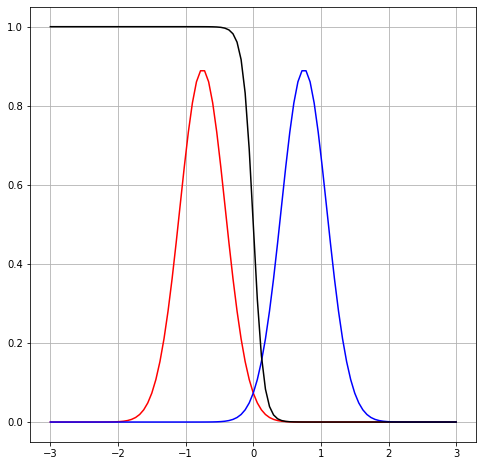

In [270]:
plt.figure(figsize=(8,8));
dist0 = mnorm([-1.0],[0.2]);
dist1 = mnorm([+1.0],[0.2]);
pdf0 = dist0.pdf(np.linspace(-4,4,101));
pdf1 = dist1.pdf(np.linspace(-4,4,101));
plt.plot(np.linspace(-3,3,101),pdf0,c='r');
plt.plot(np.linspace(-3,3,101),pdf1,c='b');
pdf_balance = pdf0 / (pdf0+pdf1);
plt.plot(np.linspace(-3,3,101),pdf_balance,'k');
plt.grid()


plt.subplot(1,2,2)
idx0 = np.where(pred_labels == 0)[0]
idx1 = np.where(pred_labels == 1)[0]
plt.scatter(Xgauss[idx0,0],Xgauss[idx0,1],color=(0,0.5,0),s=50,zorder=100)
plt.scatter(Xgauss[idx1,0],Xgauss[idx1,1],color=(1.0,0.0,0.5),s=50,zorder=100)
plt.xlabel('x',fontsize=22,**csfont);
plt.ylabel('y',fontsize=22,**csfont,rotation=0);
plt.yticks(np.linspace(-2,2,resolution),labels=np.linspace(-2,2,resolution),fontsize=14,**csfont);
plt.xticks(np.linspace(-2,2,resolution),labels=np.linspace(-2,2,resolution),fontsize=14,**csfont);
plt.grid()
plt.axis((-2,2,-2,2))
plt.title('K-means result\n',fontsize=22,**csfont,pad=10);
plt.savefig('../../assets/matplotlib/017_distance_clustering_fail2.png',dpi=300,bbox_inches="tight")

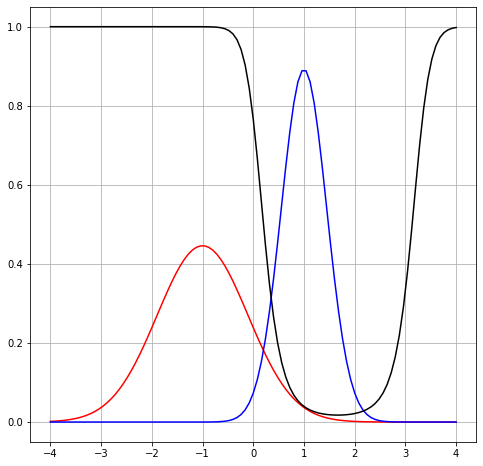

In [271]:
plt.figure(figsize=(8,8));
dist0 = mnorm([-1.0],[0.8]);
dist1 = mnorm([+1.0],[0.2]);
pdf0 = dist0.pdf(np.linspace(-4,4,101));
pdf1 = dist1.pdf(np.linspace(-4,4,101));
plt.plot(np.linspace(-4,4,101),pdf0,c='r');
plt.plot(np.linspace(-4,4,101),pdf1,c='b');
pdf_balance = pdf0 / (pdf0+pdf1);
plt.plot(np.linspace(-4,4,101),pdf_balance,'k');
plt.grid()

### Using Gaussian Mixture Models to Cluster
We observed that under certain circumstances, k-means is limited in how well it can accurately find clusters. Since it does not take into account the covariance between dimensions of the data, such covariance if it is present can lead to poor and misleading results, as we saw above. Gaussian models can take into account such covariance, provided it can be appromixated by coviarance arising from a number multivariate gaussian processes (one for each cluster) that mix together to produce the observed data. A depature from these assumptions will also render gaussian mxiture models inappropriate is this deparature is large enough. However, since we created the data aboce specifically using multivariate gaussians, GMM are obviously a valid choice. 

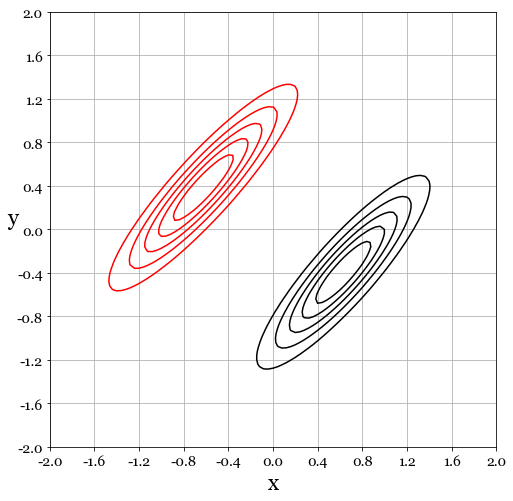

In [303]:
gmm = GaussianMixture(n_components=2, covariance_type="full")
gmm.fit(Xgauss)
distr0 = mnorm(clf.means_[0],gmm.covariances_[0])
distr1 = mnorm(clf.means_[1],gmm.covariances_[1])

res = 101
x = np.linspace(-2.0, 2.0,res)
y = np.linspace(-2.0, 2.0,res)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
distr0pdf = distr0.pdf(XX)
distr1pdf = distr1.pdf(XX)
Z0 = np.reshape(distr0pdf,(res,res))
Z1 = np.reshape(distr1pdf,(res,res))
Z0 = Z0 / np.max(Z0) 
Z1 = Z1 / np.max(Z1)

plt.figure(figsize=(8,8))
plt.contour(X, Y, Z0, colors='k', levels=np.linspace(0, 1.0, 7))
plt.contour(X, Y, Z1, colors='r', levels=np.linspace(0, 1.0, 7))
plt.xlabel('x',fontsize=22,**csfont);
plt.ylabel('y',fontsize=22,**csfont,rotation=0);
plt.xticks(np.linspace(-2,2,11),labels=np.linspace(-2,2,11),fontsize=14,**csfont);
plt.yticks(np.linspace(-2,2,11),labels=np.linspace(-2,2,11),fontsize=14,**csfont);
plt.grid()

### When both Kmeans and Gaussian Methods fail
An often used synthetic data to point out the limitation of both K-means and Gaussian methods is the two half moon cluster data set (pictured below). To a human observer, the two clusters are self-evident. To both K-means and GMM, they are far from obvious. K-means will not convergence on meaningful clusters because it uses centroids to represent each cluster. The assumption is that the centroids are representative of the clusters. In the example below, however, the centroid of each cluster is actually closest to points of the other cluster! As a result, K-means fails to find the two clearly distincy clusters in this particular dataset. Similarly, it should also not be surprising a GMM will not fare any better. The data clearly doesn't follow some gaussian generative process, and the GMM has no way of accounting for the semicircle nature of our data. 

### Half Moon Dataset 

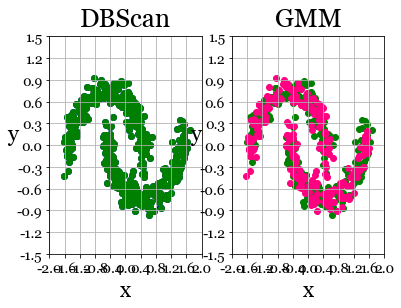

In [360]:
n_samples = 500
cluster_colors = np.array([[0,0.5,0],[1.0,0.0,0.5]])
Xmoons,ymoons = datasets.make_moons(n_samples=n_samples, noise=0.05)
Xmoons[:,0] = Xmoons[:,0] - 0.50
Xmoons[:,1] = Xmoons[:,1] - 0.25

gmm = GaussianMixture(n_components=2, covariance_type="full")
gmm.fit(Xmoons)
kmeans = KMeans(n_components=2, covariance_type="full")
kmeans.fit(Xmoons)



plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
for i in range(2):
    idx = np.where(dbscan.labels_ == i)[0]
    plt.scatter(Xmoons[idx,0],Xmoons[idx,1],color=cluster_colors[i,:])
plt.xlabel('x',fontsize=22,**csfont);
plt.ylabel('y',fontsize=22,**csfont,rotation=0);
plt.xticks(np.linspace(-2,2,11),labels=np.linspace(-2,2,11),fontsize=14,**csfont);
plt.yticks(np.linspace(-1.5,1.5,11),labels=np.linspace(-1.5,1.5,11),fontsize=14,**csfont);
plt.title('DBScan',pad=10,fontsize=26,**csfont,rotation=0);
plt.grid()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
for i in range(2):
    idx = np.where(dbscan.labels_ == i)[0]
    plt.scatter(Xmoons[idx,0],Xmoons[idx,1],color=cluster_colors[i,:])
plt.xlabel('x',fontsize=22,**csfont);
plt.ylabel('y',fontsize=22,**csfont,rotation=0);
plt.xticks(np.linspace(-2,2,11),labels=np.linspace(-2,2,11),fontsize=14,**csfont);
plt.yticks(np.linspace(-1.5,1.5,11),labels=np.linspace(-1.5,1.5,11),fontsize=14,**csfont);
plt.title('DBScan',pad=10,fontsize=26,**csfont,rotation=0);
plt.grid()


# plt.subplot(1,2,2)
# for i in range(2):
#     idx = np.where(gmm_labels == i)[0]
#     plt.scatter(Xmoons[idx,0],Xmoons[idx,1],color=cluster_colors[i,:])
# plt.xlabel('x',fontsize=22,**csfont);
# plt.ylabel('y',fontsize=22,**csfont,rotation=0);
# plt.xticks(np.linspace(-2,2,11),labels=np.linspace(-2,2,11),fontsize=14,**csfont);
# plt.yticks(np.linspace(-1.5,1.5,11),labels=np.linspace(-1.5,1.5,11),fontsize=14,**csfont);
# plt.title('GMM',pad=10,fontsize=26,**csfont,rotation=0);
# plt.grid()

# Density Based Clustering
When both a distance (K-means) and distribution (Gaussian Mixture Model) fail, a density based clustering based method can be used instead. The most popular of which is DBSCAN. Instead of the user needing to specify the number of clusters, DBSCAN relies on two other user-defined paramters. First, the mininum number of points within some distance needed for that point to be considered a 'core point', referred to as minPts. Second we will need to specify a maximum distance below which two points are still considered neighbors. In DBScan, points not only have a cluster label, they are also designation by the algorithm as 'core', 'border', 'noise'. Core points are the 'inner circle' of the cluster, they are all surrounded by minPts number of other points. The border points have fewer than minPts of other points nearby, making them form the out layer or border around the core points. Finally, some points are isolated, with no points nearby as neighbors, and are therefore not labeled as being part of a cluster, but considered outliers or noise istead. Even though setting these two parameters is not trivial, it does take away the need for us to specify beforehand the number of clusters we expect. This makes it useful in its own right alone. 

### Exampe one: the half moons revisted

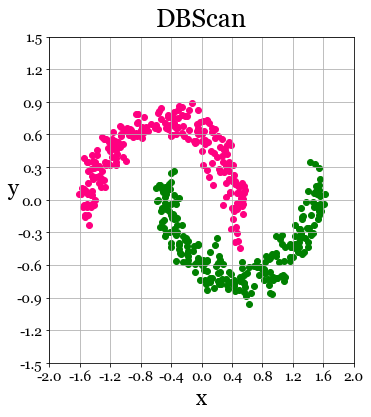

In [373]:
dbscan = DBSCAN(eps=0.10, min_samples=3).fit(Xmoons)
dbscan.labels_

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
for i in range(2):
    idx = np.where(dbscan.labels_ == i)[0]
    plt.scatter(Xmoons[idx,0],Xmoons[idx,1],color=cluster_colors[i,:])
plt.xlabel('x',fontsize=22,**csfont);
plt.ylabel('y',fontsize=22,**csfont,rotation=0);
plt.xticks(np.linspace(-2,2,11),labels=np.linspace(-2,2,11),fontsize=14,**csfont);
plt.yticks(np.linspace(-1.5,1.5,11),labels=np.linspace(-1.5,1.5,11),fontsize=14,**csfont);
plt.title('DBScan',pad=10,fontsize=26,**csfont,rotation=0);
plt.grid()

In [331]:
Xdense = np.zeros((1,2))
cval = []
no_points = 10
for i in range(360):
    rad = i / 180 * np.pi
    x = np.cos(rad)
    y = np.sin(rad)   
    no_cur_points = ((((np.sin(rad*4)+1) / 2) * no_points)**1.1)
    no_cur_points = 1 + int(no_cur_points/1.1)
    r = np.random.random(no_cur_points) + 1.0
    x = x * r * 2
    y = y * r * 2
    xy = np.vstack((x,y)).T
    Xdense = np.vstack((Xdense,xy))
Xdense = Xdense[1:,:]

In [259]:
cval = np.array(cval)
#plt.plot(cval[:,0],cval[:,1])

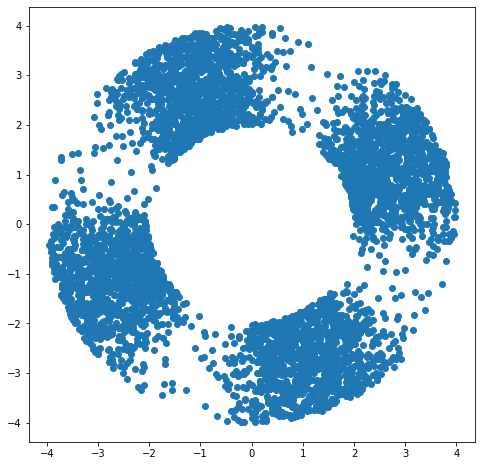

In [260]:
plt.figure(figsize=(8,8))
plt.scatter(Xdense[:,0],Xdense[:,1])